# Deep Learning - Project 1
---

Notebook for training models in cloud

### 1. Downloading the data

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mengcius/cinic10")
print(path)

100%|██████████| 754M/754M [00:05<00:00, 147MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/mengcius/cinic10/versions/1


### 2. Code
---

Custom models

In [11]:
import torch
from torch import nn
import torch.nn.functional as F

class AlexNet_32x32(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.5) -> None:
        super().__init__()
        # Convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=1)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=1)

        self.conv3 = nn.Conv2d(192, 256, kernel_size=3, stride=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.relu = nn.ReLU(inplace=True)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Classification
        self.dropout1 = nn.Dropout(dropout)
        self.lin1 = nn.Linear(256 * 4 * 4, 4096)

        self.dropout2 = nn.Dropout(dropout)
        self.lin2 = nn.Linear(4096, 4096)

        self.dropout3 = nn.Dropout(dropout)
        self.lin3 = nn.Linear(4096, num_classes)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.maxpool1(self.relu(self.conv1(x)))
        x = self.maxpool2(self.relu(self.conv2(x)))
        x = self.maxpool3(self.relu(self.conv3(x)))
        x = self.maxpool4(self.relu(self.conv4(x)))

        x = self.global_avg_pool(x)

        x = torch.flatten(x, 1)

        x = self.lin1(self.dropout1(x))
        x = self.lin2(self.dropout2(x))
        x = self.lin3(self.dropout3(x))

        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsampler = None):
        super().__init__()
        self.downsampler = downsampler

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        identity = x
        if self.downsampler is not None:
            identity = self.downsampler(identity)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out = out + identity
        out = self.relu(out)
        return out


class ResNet_32x32(nn.Module):
    def __init__(self, num_classes: int = 10, block: nn.Module = ResidualBlock):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, (3, 3), stride=1, padding=1)
        self.bnorm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.res_layer1 = self._residual_layer(block, 64, 128, 2)

        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.res_layer2 = self._residual_layer(block, 128, 256, 2)

        self.max_pool3 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.res_layer3 = self._residual_layer(block, 256, 512, 2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.lin = nn.Linear(512, num_classes)


    def _residual_layer(self, block, in_channels, out_channels, blocks_num, stride=1):
        """Creates a residual layer consisting out of residual blocks"""
        downsampler = None
        if stride != 1 or in_channels != out_channels:
            downsampler = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(in_channels, out_channels, stride, downsampler))
        for _ in range(blocks_num - 1):
            layers.append(block(out_channels, out_channels, stride))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.relu(self.bnorm(self.conv(x)))

        x = self.res_layer1(self.max_pool1(x))
        x = self.res_layer2(self.max_pool2(x))
        x = self.res_layer3(self.max_pool3(x))

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.lin(x)
        return x

Utils

In [12]:
import numpy as np
import torch
import random


def set_seed(seed: int):
    random.seed(seed)
    np.random.RandomState(seed)
    torch.manual_seed(seed)

def get_device():
    return "cuda:0" if torch.cuda.device_count() > 0 else 'cpu'


Data preparation

In [13]:
import os
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms


CINIC_MEAN = [0.47889522, 0.47227842, 0.43047404]
CINIC_STD = [0.24205776, 0.23828046, 0.25874835]


def get_dataset(
        path: str,
        batch_size: int,
        shuffle: bool,
        use_augmentations: bool,
) -> DataLoader:
    augmentations = ([
        # TODO: add augmentations
    ] if use_augmentations else [])
    transform = transforms.Compose([*augmentations,
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=CINIC_MEAN,std=CINIC_STD)])

    ds = torchvision.datasets.ImageFolder(path, transform=transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)
    return loader


def get_cinic(
        data_path: str,
        batch_size: int = 256
) -> tuple[DataLoader, DataLoader, DataLoader]:
    train_path = os.path.join(data_path, "train")
    valid_path = os.path.join(data_path, "valid")
    test_path = os.path.join(data_path, "test")

    cinic_train = get_dataset(train_path, batch_size, True, True)
    cinic_validation = get_dataset(valid_path, batch_size, False, False)
    cinic_test = get_dataset(test_path, batch_size, False, False)

    return cinic_train, cinic_validation, cinic_test


Train

In [ ]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from tqdm import tqdm


MODELS = {
    "AlexNet": AlexNet_32x32,
    "ResNet": ResNet_32x32
}

OPTIMIZERS = {
    "SGD": SGD,
    "AdamW": AdamW
}

SCHEDULERS = {
    "ExponentialLR": ExponentialLR
}


def train(config: dict, data_path: str):
    print("Starting training:")

    # Set seed for reproducibility
    seed = int(config["seed"]) if "seed" in config else 0
    set_seed(seed)
    print("Setting seed:", seed)


    device = get_device()
    print("Device: ", device)

    checkpoint = config["checkpoint_folder"]
    checkpoint = os.path.abspath(checkpoint)
    os.makedirs(checkpoint, exist_ok=True)
    print("Checkpoint folder:", checkpoint)

    with open(os.path.join(checkpoint, "config.json"), "w") as f:
        f.write(json.dumps(config))

    batch_size = int(config["batch_size"]) if "batch_size" in config else 256
    print("Batch size:", batch_size)
    cinic_train, cinic_valid, cinic_test = get_cinic(data_path, batch_size=batch_size)
    model: nn.Module = MODELS[config["model"]](**config["model_params"]).to(device)
    print("Model:", config["model"])
    print("Model params:", config["model_params"])
    optimizer: torch.optim.Optimizer = OPTIMIZERS[config["optimizer"]](params=model.parameters(),
                                                **config["optimizer_params"])
    print("Optimizer:", optimizer)
    scheduler = (
        SCHEDULERS[config["scheduler"]](optimizer, **config["scheduler_params"])
        if "scheduler" in config else None
    )
    print("Scheduler:", scheduler)
    criterion = nn.CrossEntropyLoss()

    epochs = int(config["epochs"])
    print("Number of epochs: ", epochs)
    metrics = {"loss": [float("+inf")], "accuracy": [0.0], "val_loss": [float("+inf")], "val_accuracy": [0.0]}
    best_model = model
    warmup_epochs = int(config["warmup_epochs"])
    print("Warmup epochs:", warmup_epochs)

    best_loss = float('inf')
    best_loss_epoch = -1

    classes = cinic_test.dataset.classes
    classes = sorted(classes, key=lambda x: cinic_test.dataset.class_to_idx[x])

    # Training
    for epoch in range(epochs):
        print("Epoch", epoch)

        print("Processing training")
        model.train()
        accuracy, loss = train_epoch(model, cinic_train, optimizer, criterion)
        metrics["accuracy"].append(accuracy)
        metrics["loss"].append(loss)

        print("Processing validation")
        model.eval()
        val_accuracy, val_loss = valid_epoch(model, cinic_valid, criterion)
        metrics["val_accuracy"].append(val_accuracy)
        metrics["val_loss"].append(val_loss)

        print(f"Loss: {metrics['loss'][-1]:.4f}", end=' ')
        print(f"Accuracy: {metrics['accuracy'][-1]:.4f}", end=' ')
        print(f"Validation Loss: {metrics['val_loss'][-1]:.4f}", end=' ')
        print(f"Validation Accuracy: {metrics['val_accuracy'][-1]:.4f}")
        print()

        # Saving checkpoint
        if epoch >= warmup_epochs and val_loss < metrics["val_loss"][-2]:
            best_model = model
            torch.save({
                    "model_state": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "loss": criterion.state_dict(),
                    "epoch": epoch
            }, os.path.join(checkpoint, "state.pth"))

        # Early stopping
        if "early_stopping" in config:
            if config["early_stopping"]["min_delta"] < best_loss - val_loss:
                best_loss_epoch = epoch
                best_loss = val_loss
            elif epoch - best_loss_epoch >= config["early_stopping"]["patience"]:
                print("Early stopping!")
                break

        # Scheduler step
        if scheduler is not None:
            scheduler.step()

    # Calculate test metrics and confusion matrix
    df_metrics = pd.DataFrame(metrics)
    df_metrics.to_csv(os.path.join(checkpoint, "metrics.csv"))
    save_results(checkpoint, best_model, cinic_test, criterion, classes)


def train_epoch(
    model: nn.Module,
    train_ds: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.CrossEntropyLoss
):
    losses = []
    accuracies = []
    batch_sizes = []
    for input, target in tqdm(train_ds):
        optimizer.zero_grad()

        input, target = input.cuda(), target.cuda()
        ohe_target = F.one_hot(target, 10).type(torch.float32)
        output = model(input)
        loss = criterion(output, ohe_target)

        loss.backward()
        optimizer.step()

        pred = torch.argmax(output, dim=-1)
        accurate_pred = (pred == target).type(torch.float32)
        accuracies.append(torch.mean(accurate_pred).item())

        losses.append(loss.item())
        batch_sizes.append(len(input))

    accuracy = np.average(accuracies, weights=batch_sizes)
    loss = np.average(losses, weights=batch_sizes)
    return accuracy, loss


def valid_epoch(
    model: nn.Module,
    valid_ds: DataLoader,
    criterion: nn.CrossEntropyLoss
):
    val_losses = []
    val_accuracies = []
    batch_sizes = []
    with torch.no_grad():
        for input, target in tqdm(valid_ds):
            input, target = input.cuda(), target.cuda()
            ohe_target = F.one_hot(target, 10).type(torch.float32)
            output = model(input)
            val_loss = criterion(output, ohe_target)

            # Calculate accuracy
            pred = torch.argmax(output, dim=-1)
            accurate_pred = (pred == target).type(torch.float32)
            val_accuracies.append(torch.mean(accurate_pred).item())

            val_losses.append(val_loss.item())
            # Store information regarding
            batch_sizes.append(len(input))

    val_accuracy = np.average(val_accuracies, weights=batch_sizes)
    val_loss = np.average(val_losses, weights=batch_sizes)
    return val_accuracy, val_loss


def test_epoch(
    model: nn.Module,
    valid_ds: DataLoader,
    criterion: nn.CrossEntropyLoss
):
    val_losses = []
    val_accuracies = []
    batch_sizes = []
    predictions = []
    targets = []

    with torch.no_grad():
        for input, target in tqdm(valid_ds):
            input, target = input.cuda(), target.cuda()
            ohe_target = F.one_hot(target, 10).type(torch.float32)
            output = model(input)
            val_loss = criterion(output, ohe_target)

            # Calculate accuracy
            pred = torch.argmax(output, dim=-1)
            accurate_pred = (pred == target).type(torch.float32)
            val_accuracies.append(torch.mean(accurate_pred).item())

            val_losses.append(val_loss.item())
            batch_sizes.append(len(input))

            predictions.append(pred)
            targets.append(target)

    val_accuracy = np.average(val_accuracies, weights=batch_sizes)
    val_loss = np.average(val_losses, weights=batch_sizes)
    predictions = torch.concatenate(predictions).cpu().numpy()
    targets = torch.concatenate(targets).cpu().numpy()
    return val_accuracy, val_loss, targets, predictions


def save_results(
        checkpoint: str,
        model: nn.Module,
        cinic_test: DataLoader,
        criterion: nn.CrossEntropyLoss,
        classes: list[str]
):
    model.eval()
    test_accuracy, test_loss, test_targets, test_predictions = test_epoch(model,
                                                                          cinic_test, criterion)
    with open(os.path.join(checkpoint, "test_metrics.txt"), "w") as f:
        f.write(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.4f}")

    # Confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(test_targets, test_predictions,
                                                   display_labels=classes)
    disp.figure_.savefig(os.path.join(checkpoint, "confusion_matrix_test.jpg"))

    # Confusion matrix without diagonal
    wrong_predictions_idx = test_targets != test_predictions
    test_targets = test_targets[wrong_predictions_idx]
    test_predictions = test_predictions[wrong_predictions_idx]
    disp = ConfusionMatrixDisplay.from_predictions(test_targets, test_predictions,
                                                   display_labels=classes)
    disp.figure_.savefig(os.path.join(checkpoint, "confusion_matrix_test_no_diag.jpg"))

### 3. Training
---

Starting training:
Setting seed: 42
Device:  cuda:0
Checkpoint folder: d:\Dev\DeepLearning\CINIC10_CNN_Classifier\checkpoints\test_resnet_256_sgd
Batch size: 256
Model: ResNet_32x32(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (max_pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (res_layer1): Sequential(
    (0): ResidualBlock(
      (downsampler): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2

100%|██████████| 352/352 [00:44<00:00,  7.94it/s]


Processing validation


100%|██████████| 352/352 [00:29<00:00, 11.76it/s]


Loss: 1.2353 Accuracy: 0.5499 Validation Loss: 1.0859 Validation Accuracy: 0.6083



100%|██████████| 352/352 [00:30<00:00, 11.70it/s]


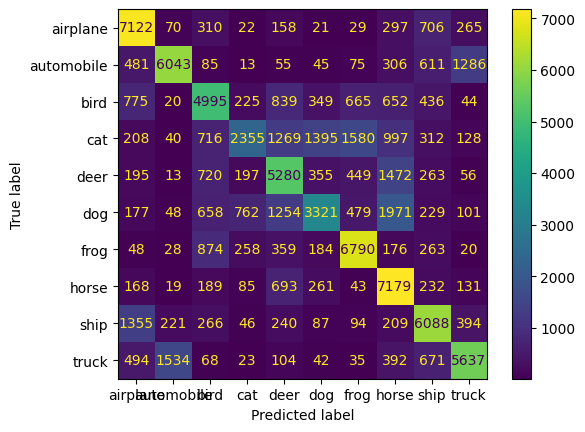

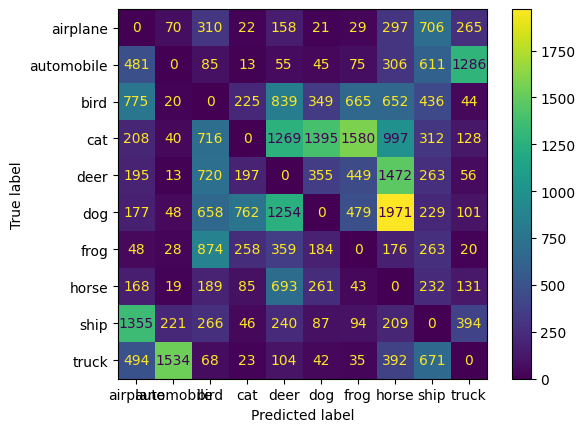

In [16]:
configs = [
    {
        "seed": 42,
        "model": "ResNet",
        "model_params": {},

        "optimizer": "SGD",
        "optimizer_params": {
            "lr": 1e-2,
            "momentum": 0.9,
            "nesterov": True,
            "weight_decay": 0.01
        },

        "epochs": 1,
        "batch_size": 256,

        "checkpoint_folder": "../checkpoints/test_resnet_256_sgd",
        "warmup_epochs": 0,

        "scheduler": "ExponentialLR",
        "scheduler_params": {
            "gamma": 0.9,
        },

        "early_stopping": {
            "patience": 5,
            "min_delta": 0.001
        }
    }
]

train(configs[0], "../data")